# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

During the competition, I took into account the enlightments provided by others kernels, and included a few features that appeared to be important. In particular, I closely looked at the following kernels (ordered by release time):
1.  [You're Going to Want More Categories [LB 3.737] by Peter Hurford](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737)
2. [EloDA with Feature Engineering and Stacking by Bojan Tunguz](https://www.kaggle.com/tunguz/eloda-with-feature-engineering-and-stacking)
3. [A Closer Look at Date Variables by Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables)
4. [LGB + FE (LB 3.707) by Konrad Banachewicz](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)
5. [My first kernel (3.699) by Chau Ngoc Huynh](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
new_transactions = pd.read_csv('data\\new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('data\\historical_transactions.csv',
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

We then load the main files, formatting the dates and extracting the target:

In [ ]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#_________________________________________

train = read_data('data\\train.csv')
test = read_data('data\\test.csv')

target = train['target']
del train['target']

<a id="2"></a> <br>
## Feature engineering
Following [Chau Ngoc Huynh's kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/), I add the following features:

In [ ]:
bins = historical_transactions.groupby(['city_id',])['merchant_id'].nunique()

In [ ]:
def bfunc(x):
    for pair in [(10000,1),(7000,2),(4000,3),(1000,4),(700,5),(300,6),(0,7)]:
        if x > pair[0]:
            return pair[1]
        
reps = {x:bfunc(y) for x,y in bins.iteritems()}
reps[-1] = 10

In [ ]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [ ]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

#historical_transactions = reduce_mem_usage(historical_transactions)
#new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [ ]:
#modded stop

In [ ]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month


In [ ]:
def purch_info(dt):
    cdates = dt.groupby(['card_id'])['purchase_date'].agg({'purchase_date':['max','min','nunique'],
                                                              }).reset_index()
    dt = pd.merge(dt, cdates,  how='outer', on=['card_id'])
    dt.columns = ['_'.join(col).strip() if col[0] == 'purchase_date' else col for col in dt.columns.values]
    
    
    dt['days_activity'] = (dt.purchase_date_max - dt.purchase_date_min).dt.days + 1
    dt['months_activity'] =  (dt['days_activity'] //30) + 1
    cpur = dt.groupby(['card_id','purchase_month'])['purchase_date'].agg({'purchase_date':['nunique'],
                                                             }).reset_index()
    dt = pd.merge(dt, cpur,  how='outer', on=['card_id','purchase_month'])
    dt.columns = ['purchases_per_month' if col[1] == 'nunique' else col for col in dt.columns.values]
    return dt

In [ ]:
historical_transactions = purch_info(historical_transactions)
authorized_transactions = purch_info(authorized_transactions)
new_transactions = purch_info(new_transactions)

In [ ]:
def new_dcats(dt):
    dt['month_purchase_end'] = dt['purchase_date'].dt.is_month_end.astype('int8')
    dt['month_purchase_start'] = dt['purchase_date'].dt.is_month_start.astype('int8')
    dt['purchase_week_day'] = (dt['purchase_date'].dt.weekday > 5).astype('int8')
    dt['quartal_purchase'] = (dt['purchase_date'].dt.quarter + 1).astype('int8')
    dt = pd.get_dummies(dt,columns=['quartal_purchase'],prefix='quartal')
    dt['purchase_hours'] = ((dt['purchase_date'].dt.hour > 7) & (dt['purchase_date'].dt.hour < 22))
    #dt['purchase_amount_log'] = np.log10(np.square(dt.purchase_amount))  
    return dt

historical_transactions = new_dcats(historical_transactions)
authorized_transactions = new_dcats(authorized_transactions)
new_transactions = new_dcats(new_transactions)

In [ ]:
#new_transactions.purchase_amount_log.replace([np.inf, -np.inf], np.nan,inplace=True)

In [ ]:
#historical_transactions.purchase_amount_log.fillna(historical_transactions.purchase_amount_log.mean(),inplace=True)
#authorized_transactions.purchase_amount_log.fillna(authorized_transactions.purchase_amount_log.mean(),inplace=True)
#new_transactions.purchase_amount_log.fillna(new_transactions.purchase_amount_log.mean(),inplace=True)

In [ ]:
#replaced 
historical_transactions['city_bins'] = historical_transactions.city_id.replace(reps)
authorized_transactions['city_bins'] = authorized_transactions.city_id.replace(reps)
new_transactions['city_bins'] = new_transactions.city_id.replace(reps)

In [ ]:
print('hello')

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [ ]:
#

In [ ]:
#historical_transactions.to_feather('out\\ht')
#authorized_transactions.to_feather('out\\au')
#new_transactions.to_csv('out\\new_trans.csv')

In [ ]:
#historical_transactions = feather.read_dataframe('out\\ht')
#authorized_transactions = feather.read_dataframe('out\\au')
#new_transactions = pd.read_csv('out\\new_trans.csv')


In [ ]:
def count_missing(dt):
    missing = []
    for x in dt.columns.values:
        missing.append(len(dt[x]) - dt[x].count())
    return pd.DataFrame([dt.columns.values,missing])

In [ ]:
def modeplus(x):
    return mode(x)[0]

#exclude 'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique','median'],
    'subsector_id': ['nunique'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean'],
    'month_purchase_end': ['mean','median'],
    'month_purchase_start': ['mean','median'],
    'purchase_week_day': ['mean'],
    'city_bins': [modeplus],
    'quartal_2': ['mean'],
    'quartal_3': ['mean'],
    'quartal_4': ['mean'],
    'quartal_5': ['mean'],
    'purchase_hours': ['mean'],
#    'purchase_amount_log':['sum', 'mean', 'max', 'min', 'std'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
#    'purchase_date':['max','min'],
    'purchase_date_nunique':['max'],
    'days_activity':['max'],
    'months_activity':['max'],
    'purchases_per_month':['min','max','mean']
    
    }
    
#purchase_date_nunique	days_activity	months_activity	purchases_per_month    

    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [ ]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

In [ ]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

In [ ]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [ ]:
#replaced 'purchase_amount': ['count', 'sum', 'mean',modeplus, 'min', 'max', 'std']
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean',modeplus, 'min', 'max', 'std'],
#            'purchase_amount_log': ['count', 'sum', 'mean',modeplus, 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean',modeplus, 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

#___________________________________________________________

final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

In [ ]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [ ]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')


In [ ]:
count_missing(additional_fields)

In [ ]:
additional_fields.shape

<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [ ]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [ ]:
# cols = [c for c in train if c.startswith('hist')]
# train.loc[train['hist_transactions_count'].isnull(), cols] = 0
# test.loc[test['hist_transactions_count'].isnull(), cols] = 0

# cols = [c for c in train if c.startswith('new')]
# train.loc[train['new_transactions_count'].isnull(), cols] = 0
# test.loc[test['new_transactions_count'].isnull(), cols] = 0

In [ ]:
# cols = [c for c in train if c.endswith('std')]
# for c in cols:
#     train.loc[train[c].isnull(), c] = 0
#     test.loc[test[c].isnull(), c] = 0

In [ ]:
# train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
# test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

In [ ]:
# hist_columns = [(c, c.replace('new', 'auth')) for c in train.columns if 'hist' in c]
# for c in hist_columns:
#     col_name = 'ratio_{}_{}'.format(c[0], c[1])
#     train[col_name] = train[c[0]] / train[c[1]]
#     test[col_name] = test[c[0]] / test[c[1]]

In [ ]:
train['target'] = target

In [ ]:
feather.write_dataframe(train,'out\\train')
feather.write_dataframe(test,'out\\test')

and to define the features we want to keep to train the model. For that purpose, I use the results obtained in the [Selecting features kernel](https://www.kaggle.com/fabiendaniel/selecting-features/notebook):

We then set the hyperparameters of the LGBM model, these parameters are obtained by an [bayesian optimization done in another kernel](https://www.kaggle.com/fabiendaniel/hyperparameter-tuning/edit):

In [ ]:
max_tar = train[train.target > 4].describe()
max_tar.rename({x:('max_'+x) for x in max_tar.index.values},axis='index',inplace=True)
mid_tar = train[((train.target > -8) & (train.target < 4))].describe()
mid_tar.rename({x:('mid_'+x) for x in mid_tar.index.values},axis='index',inplace=True)
min_tar = train[train.target < -8].describe()
min_tar.rename({x:('min_'+x) for x in min_tar.index.values},axis='index',inplace=True)
comparisons = pd.concat([max_tar,mid_tar,min_tar])
indexs = []
[indexs.extend(x) for x in zip(min_tar.index.values,mid_tar.index.values,max_tar.index.values)]
comparisons = comparisons.reindex(index=indexs)
comparisons

In [ ]:
train[train.target > 8].describe()

In [ ]:
####################

In [ ]:
train = feather.read_dataframe('out\\train')
test = feather.read_dataframe('out\\test')
target = pd.read_csv('target2',header=None,index_col=0)

In [ ]:
add_col_train = add_col_train[['card_id','length_of_activity_in_mpnths','last_payments_month']]
add_col_test = add_col_test[['card_id','length_of_activity_in_mpnths','last_payments_month']]

In [ ]:
train = pd.merge(train, add_col_train, on='card_id', how='left')
test = pd.merge(test, add_col_test, on='card_id', how='left')

In [ ]:
train.length_of_activity_in_mpnths,last_payments_month

In [ ]:
#####################

In [15]:
######## pivoted cats and end to starts months buyings ########
train = feather.read_dataframe('cat_and_etb\\train_cats_and_etb')
test = feather.read_dataframe('cat_and_etb\\test_cats_and_etb')
target = train.pop('target')
############################################################ 
#to_drop (0.1): ['15_month_installments_sum', 'cat2_2_purchases_mean', '3_month_installments_std']

['15_month_installments_sum',
 'cat2_2_purchases_mean',
 '3_month_installments_std']

In [ ]:
# 221,testcol_feature_1
# 222,testcol_feature_2
# 223,testcol_agged_all_installments_mean
# 224,testcol_agged_all_installments_std
# 225,testcol_agged_all_merchant_category_id_modeplus
# 226,testcol_agged_all_purchase_amount_sum
# 227,testcol_agged_all_purchase_amount_mean
# 228,testcol_agged_all_undefined_installments_min
# 229,testcol_eb_all_purchase_amount_sum_mean_PM
# 230,testcol_eb_all_purchase_amount_max_std_PM
# 231,testcol_ml_all_month_lag_mean_PM
# 232,testcol_agged_au_purchase_date_all_weeks_ptp
# 233,testcol_agged_non_merchant_category_id_nunique
# 234,testcol_agged_non_month_lag_mean


In [43]:
################ everything ################
ver2train = feather.read_dataframe('train')
ver2test = feather.read_dataframe('test')
########################################

In [ ]:
target = pd.read_csv('target2',header=None,index_col=0)

In [ ]:
best_cols = pd.read_csv('tttt',usecols=[1])

In [ ]:
train = train[best_cols['0'].values]
test = test[best_cols['0'].values]

In [2]:
################ table one after another tests ################
train = feather.read_dataframe('ensemble\\top_train')
test = feather.read_dataframe('ensemble\\top_test')
################################################################

In [3]:
target = pd.read_csv('target2',header=None,index_col=0)

In [ ]:
train = train.drop(ndrop,axis=1)
test = test.drop(ndrop,axis=1)

In [ ]:
filled = []
needs_modding=[]

In [ ]:
def fill_by_mean(dt,cols=None,fill=True):
    global filled
    global needs_modding
    
    if not cols:
        cols = [x for x in dt.columns.values][2:]
    for x in cols:
        if (len(dt[x]) - dt[x].count()):
            dt['missing_' + x] = dt[x].isna()
            filled.append(f'missing_{x}')           
            needs_modding.append(x)
            dt[x].fillna(dt[x].mean(),inplace=True)
            z = np.abs(stats.zscore(dt[x]))
            dt['outliners_' + x] = (z > 3)
            filled.append(f'outliners_{x}')
                
    return dt

In [ ]:
train = fill_by_mean(train)

In [ ]:
test = fill_by_mean(test,needs_modding)

In [ ]:
train = train.drop(['hist_purchase_date_min','auth_category_1_sum','auth_purchase_date_min',
       'auth_purchase_date_max','auth_purchase_amount_min','new_category_1_sum','new_purchase_date_min',
       'new_purchase_date_max','new_purchase_amount_sum',
       'new_purchase_amount_max', 'new_purchase_amount_min',
       'new_purchase_amount_std','purchase_amount_mean_mean','purchase_amount_max_std',],axis=1)

In [ ]:
filled = []

In [ ]:
new_feats = []
for cf in categorical_feats:
    if cf in features:
        new_feats.append(cf)

In [ ]:
train.hist_month_diff_mean = np.log(train['hist_month_diff_mean'])
train['hist_installments_sum'] = np.square(train['hist_installments_sum'])
train['elapsed_time'] = np.square(train['elapsed_time'])

In [ ]:
categorical_feats = new_feats

In [ ]:
#     param = {'num_leaves': 50, #checked
#              'num_threads': 4,
#              'max_bin': 75, #checked
#              'min_data_in_leaf': 100, #checked 
#              'objective':'regression',
#              'max_depth': 5, #checked
#              'tree_learner':'data',
#              'learning_rate': 0.03,
#              "boosting": "gbdt", #dart, gbdt
#              "feature_fraction": 0.9, #checked
#              "bagging_freq": 5,
#              "bagging_fraction": 0.9, #checked
#              "bagging_seed": 11,
#              "metric": 'rmse',
#              "lambda_l1": 0.3, #checked
# #            'lambda_l2': 0.3, #checked
#              "random_state": 77,
#              "verbosity": -1}

In [ ]:
# param = {'num_leaves': 111,
#          'min_data_in_leaf': 149, 
#          'objective':'regression',
#          'max_depth': 9,
#          'learning_rate': 0.005,
#          "boosting": "gbdt",
#          "feature_fraction": 0.7522,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.7083 ,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.2634,
#          "random_state": 133,
#          "verbosity": -1}

In [ ]:
#basic calc

In [4]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [x for x in train.columns.values if len(train[x].unique()) < 15]

In [5]:
all_cat_feat = ['feature_1','feature_2','feature_3','hist_state_id_nunique', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_month_purchase_end_median',
 'hist_month_purchase_start_median', 'hist_city_bins_modeplus', 'auth_installments_max', 'auth_installments_min', 'auth_purchase_month_max', 'auth_purchase_month_min', 'auth_month_lag_max', 'auth_month_lag_min', 'auth_month_purchase_end_median', 'auth_month_purchase_start_median',
 'auth_city_bins_modeplus', 'new_state_id_nunique', 'new_purchase_month_max', 'new_purchase_month_min', 'new_month_lag_max', 'new_month_lag_min', 'new_month_purchase_end_median', 'new_month_purchase_start_median', 'new_city_bins_modeplus', 'new_months_activity_max', 'last_payments_month']

In [6]:
categorical_feats = all_cat_feat

In [ ]:
combination = pd.concat([train,test],axis=0)

In [ ]:
for x in [x for x in categorical_feats if re.search('month_lag',x)]:
    combination[x] = np.abs(combination[x].values)

In [ ]:
for x in categorical_feats:
    val_max = combination[x].max()
    combination[x] = combination[x].replace({-1:val_max+1,np.nan:val_max+2})

In [ ]:
train = combination.iloc[:201917,:]
test = combination.iloc[201917:,:]

In [ ]:
train['new_purchase_month_min'].isna().sum()

In [ ]:

#features = [f for f in features if f not in unimportant_features]

In [ ]:
columns_in

In [25]:
features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [x for x in train_df.columns.values if (x in all_cat_feat)]

In [27]:
train = train[columns_in]
test = test[columns_in]

In [18]:
train.head()

,card_id,feature_1,feature_2,feature_3,days_to_start,days_to_end,authorized_flag_mean,city_id_mean,city_id_std,city_id_modeplus,city_id_nunique,category_1_mean,installments_mean,installments_std,installments_sum,installments_non_zero_mean,installments_count_non_zeros,installments_non_zero_percent,merchant_category_id_mean,merchant_category_id_std,merchant_category_id_modeplus,merchant_category_id_nunique,month_lag_table_ends,month_lag_nunique,purchase_amount_mean,purchase_amount_sum,purchase_amount_top_quarter_quantile,purchase_amount_bottom_quarter_quantile,purchase_amount_min,purchase_amount_max,purchase_amount_std,state_id_mean,state_id_std,state_id_modeplus,state_id_nunique,subsector_id_mean,subsector_id_std,subsector_id_modeplus,subsector_id_nunique,no_city_mean,undefined_installments_mean,big_installments_mean,purchase_amount_unusual_mean,cat2_dum_0.0_mean,cat2_dum_1.0_mean,cat2_dum_2.0_mean,cat2_dum_3.0_mean,cat2_dum_4.0_mean,cat2_dum_5.0_mean,cat3_dum_A_mean,cat3_dum_B_mean,cat3_dum_C_mean,cat3_dum_nan_mean,purchase_date_day_<lambda>,purchase_date_day_ptpplus,purchase_date_day_std,purchase_date_day_min,purchase_date_day_max,purchase_date_weekend_mean,purchase_date_weekend_std,purchase_date_hour_mean,purchase_date_hour_bottom_quarter_quantile,purchase_date_hour_top_quarter_quantile,purchase_date_hour_std,purchase_date_day_cycle_mean,payment_per_month_std,number_of_purchases_max,valid_authorization_percent_max,non_installments_purchases_mean,non_installments_purchases_sum,non_installments_purchases_top_quarter_quantile,non_installments_purchases_bottom_quarter_quantile,non_installments_purchases_min,non_installments_purchases_max,non_installments_purchases_std,cat2_0_purchases_sum,cat2_0_purchases_mean,cat2_0_purchases_std,cat2_1_purchases_sum,cat2_1_purchases_mean,cat2_1_purchases_std,cat2_2_purchases_sum,cat2_2_purchases_mean,cat2_2_purchases_std,cat2_3_purchases_sum,cat2_3_purchases_mean,cat2_3_purchases_std,cat2_4_purchases_sum,cat2_4_purchases_mean,cat2_4_purchases_std,cat2_5_purchases_sum,cat2_5_purchases_mean,cat2_5_purchases_std,cat3_A_purchases_sum,cat3_A_purchases_mean,cat3_A_purchases_std,cat3_B_purchases_sum,cat3_B_purchases_mean,cat3_B_purchases_std,cat3_C_purchases_sum,cat3_C_purchases_mean,cat3_C_purchases_std,cat3_n_purchases_sum,cat3_n_purchases_mean,cat3_n_purchases_std,0_month_payments_sum,0_month_payments_mean,0_month_payments_std,1_month_payments_sum,1_month_payments_mean,1_month_payments_std,2_month_payments_sum,2_month_payments_mean,2_month_payments_std,3_month_payments_sum,3_month_payments_mean,3_month_payments_std,4_month_payments_sum,4_month_payments_mean,4_month_payments_std,5_month_payments_sum,5_month_payments_mean,5_month_payments_std,6_month_payments_sum,6_month_payments_mean,6_month_payments_std,7_month_payments_sum,7_month_payments_mean,7_month_payments_std,8_month_payments_sum,8_month_payments_mean,8_month_payments_std,9_month_payments_sum,9_month_payments_mean,9_month_payments_std,10_month_payments_sum,10_month_payments_mean,10_month_payments_std,11_month_payments_sum,11_month_payments_mean,11_month_payments_std,12_month_payments_sum,12_month_payments_mean,12_month_payments_std,13_month_payments_sum,13_month_payments_mean,13_month_payments_std,14_month_payments_sum,14_month_payments_mean,14_month_payments_std,15_month_payments_sum,15_month_payments_mean,15_month_payments_std,cat2_0_installments_sum,cat2_0_installments_mean,cat2_0_installments_std,cat2_0_installments_count_non_zeros,cat2_1_installments_sum,cat2_1_installments_mean,cat2_1_installments_std,cat2_1_installments_count_non_zeros,cat2_2_installments_sum,cat2_2_installments_mean,cat2_2_installments_std,cat2_2_installments_count_non_zeros,cat2_3_installments_sum,cat2_3_installments_mean,cat2_3_installments_std,cat2_3_installments_count_non_zeros,cat2_4_installments_sum,cat2_4_installments_mean,cat2_4_installments_std,cat2_4_installments_count_non_zeros,cat2_5_installments_sum,cat2_5_installments_mean,cat2_5_installments_std,cat2_

In [17]:
for x in train[[x for x in train.columns.values if re.search('nunique',x)]]:
    print(train[x].max(),train[x].min())

12 1
13 1
16 2
7 1
10 1


In [19]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [x for x in train.columns.values if (re.search('modeplus',x) or re.search('nunique',x) or re.search('feature_',x))]

In [33]:
outputs = []
ptest = 1
for ptest in range(1):
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 75, #checked
             'min_data_in_leaf': 100, #checked
             'objective':'regression',
             'max_depth': -1, #checked
             'tree_learner':'data',
             'learning_rate': 0.05,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5, #5
             "bagging_fraction": 0.75, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
#             'gpu_use_dp':True,
            }

    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )


        clf = lgb.train(param, trn_data,10000, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    print("CV score: {:<8.5f}".format(errr))
    outputs.append(f'{ptest}, {errr}')
    print(f'\n^ {ptest} - num leaves^ \n')

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.37227	valid_1's rmse: 3.73283
[200]	training's rmse: 3.16256	valid_1's rmse: 3.73331
[300]	training's rmse: 2.97814	valid_1's rmse: 3.73865
Early stopping, best iteration is:
[162]	training's rmse: 3.23682	valid_1's rmse: 3.73158
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.38399	valid_1's rmse: 3.66705
[200]	training's rmse: 3.17003	valid_1's rmse: 3.67379
[300]	training's rmse: 2.9951	valid_1's rmse: 3.6799
Early stopping, best iteration is:
[110]	training's rmse: 3.35801	valid_1's rmse: 3.66577
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.3932	valid_1's rmse: 3.64515
[200]	training's rmse: 3.17639	valid_1's rmse: 3.65126
Early stopping, best iteration is:
[87]	training's rmse: 3.42525	valid_1's rmse: 3.64424
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	

In [ ]:
test.drop(labels=['all_day_3_num_of_purch',
 'auth_category_3_A_mean',
 'feature_1',
 'feature_2',
 'id1_replaced_by_their_prcnt',
 'more_50prc_in_merch_cat',
 'new_month_lag_min',
 'new_month_purchase_start_median'],axis=1,inplace=True)

In [ ]:
#CV score: 3.66668 3.65611 

In [ ]:
#device=gpu gpu_device_id=0 gpu_platform_id=1

In [ ]:
#one after another addition

In [ ]:
columns_in = []

In [20]:
warnings.filterwarnings("ignore")
train_df = pd.DataFrame()
test_df = pd.DataFrame()
best_err = 0 

best_cols = []
lenght_t = len(train.columns)

for col in to_add:
    columns_in.append(col)
    
    train_df[col] = train[col]
    test_df[col] = test[col]
    
    features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month']]
    categorical_feats = [x for x in train_df.columns.values if (x in all_cat_feat)]
    
    
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 75, #checked
             'min_data_in_leaf': 100, #checked 
             'objective':'regression',
             'max_depth': 9, #checked #9
             'tree_learner':'data',
             'learning_rate': 0.03,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5,
             "bagging_fraction": 0.70, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
#             'gpu_use_dp':True,
            }
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

        clf = lgb.train(param,trn_data,10000, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    
    errr = mean_squared_error(oof, target)**0.5
    
    if best_err == 0:
        best_err = errr
    
    if errr < best_err:
        best_err = errr
        best_cols = columns_in
        print(f'{col} decreases error')
    else:
        train_df.drop(col,axis=1,inplace=True)
        test_df.drop(col,axis=1,inplace=True)
        print(f'{col} adds noise')
    
    cols_left = lenght_t - len(columns_in)
    print("CV score: {:<8.5f}".format(errr))
    print(f'cols left {cols_left}')
    
    if not (cols_left % 10):
        clear_output()

fold n°0
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.40442	valid_1's rmse: 3.67911
Early stopping, best iteration is:
[208]	training's rmse: 3.43355	valid_1's rmse: 3.67807
fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.4206	valid_1's rmse: 3.63052
Early stopping, best iteration is:
[156]	training's rmse: 3.49175	valid_1's rmse: 3.62673
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.41802	valid_1's rmse: 3.60645
Early stopping, best iteration is:
[207]	training's rmse: 3.45309	valid_1's rmse: 3.60319
fold n°3
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.37619	valid_1's rmse: 3.77967
Early stopping, best iteration is:
[228]	training's rmse: 3.39182	valid_1's rmse: 3.77926
fold n°4
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.41422	valid_1's rmse: 3.6268
Early s

fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.40307	valid_1's rmse: 3.63103
Early stopping, best iteration is:
[167]	training's rmse: 3.4693	valid_1's rmse: 3.62739
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.3989	valid_1's rmse: 3.60706
Early stopping, best iteration is:
[156]	training's rmse: 3.48034	valid_1's rmse: 3.60413
fold n°3
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.3649	valid_1's rmse: 3.77997
Early stopping, best iteration is:
[191]	training's rmse: 3.40976	valid_1's rmse: 3.77906
fold n°4
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.39626	valid_1's rmse: 3.62199
Early stopping, best iteration is:
[141]	training's rmse: 3.48652	valid_1's rmse: 3.61824
auth_month_lag_min adds noise
CV score: 3.66220 
cols left 2


In [24]:
#pd.DataFrame(columns_in).to_csv('bcolumns')

In [ ]:
#adding test

In [24]:
retest = [x for x in train.columns.values]

In [25]:
warnings.filterwarnings("ignore")
#cols = ver2cols
#cols = ver2train.columns[-200:].values 
cols = retest
#cols = list(ver2train.columns[-31:].values) + list(ver2cols)

if 'best_error' not in locals():
    best_error = 3.71281 
if 'best_cols' not in locals():
    best_cols = []
counter = len(cols)

for test_col in cols:
    
    train[test_col] = ver2train[test_col]
    
    
    features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
    #features = [f for f in features if f not in unimportant_features]
    categorical_feats = [x for x in features if (re.match('feature_[1-2]',x) or re.search('modeplus',x))]
    
    
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 75, #checked
             'min_data_in_leaf': 100, #checked 
             'objective':'regression',
             'max_depth': 9, #checked #9
             'tree_learner':'data',
             'learning_rate': 0.03,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5,
             "bagging_fraction": 0.70, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
            }

    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )

        num_round = 10000
        clf = lgb.train(param, trn_data,num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits


    errr = mean_squared_error(oof, target)**0.5
    counter-=1
    if errr > best_error:
        train.drop(test_col,axis=1,inplace=True)
        print(f'{test_col} adds noise\n {counter}')
        
    else:
        best_cols.append(test_col)
        print(f'{test_col} benefits CV\n {counter}')
        best_error = errr
        
    print("CV score: {:<8.5f}".format(errr))
    
    if not (cols_left % 10):
        clear_output()

NameError: name 'ver2train' is not defined

In [ ]:
#### MASS DROPPING TEST ####

In [38]:
warnings.filterwarnings("ignore")


best_comb = []
best_error = 3.71071

all_features = [c for c in ndrop if c not in ['card_id', 'first_active_month']]
to_check = len(all_features)

print(f"END OF THE TEST TRY\nError is {best_error}\n\nStart of the column elimination")

for num in range(to_check):
    
    features = all_features[num:]
    features_size = len(features)
    categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('nunique',x) or re.search('feature_',x))]
    
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 75, #checked
             'min_data_in_leaf': 100, #checked
             'objective':'regression',
             'max_depth': 9, #checked
             'tree_learner':'data',
             'learning_rate': 0.05,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5,
             "bagging_fraction": 0.70, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
    #            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
#             'gpu_use_dp':True,
            }

    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )

        num_round = 10000
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    errr = mean_squared_error(oof, target)**0.5

    if errr > best_error:
        print(f'{features_size} columns size is not optimal\n')
        print(f'{to_check - num} left to check')
    else:
        print(f'{features_size} columns size is optimal')
        print(f'{to_check - num} left to check')
        best_error = errr
        best_comb = features

    print("CV score:", errr,end='\n')
#    print(f'dropped columns {dropped_columns}\ncolumns left {cols_left}\n')

END OF THE TEST TRY
Error is 3.71071

Start of the column elimination
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.43992	valid_1's rmse: 3.7289
[200]	training's rmse: 3.30509	valid_1's rmse: 3.73081
[300]	training's rmse: 3.17804	valid_1's rmse: 3.736
Early stopping, best iteration is:
[119]	training's rmse: 3.41066	valid_1's rmse: 3.72704
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45828	valid_1's rmse: 3.66938
[200]	training's rmse: 3.33001	valid_1's rmse: 3.67036
Early stopping, best iteration is:
[80]	training's rmse: 3.49326	valid_1's rmse: 3.66696
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46572	valid_1's rmse: 3.6406
[200]	training's rmse: 3.32494	valid_1's rmse: 3.64592
[300]	training's rmse: 3.20699	valid_1's rmse: 3.65287
Early stopping, best iteration is:
[101]	training's rmse: 3.46457	valid_1's rmse: 3.64048
Training until validation scores don

Early stopping, best iteration is:
[112]	training's rmse: 3.43035	valid_1's rmse: 3.72719
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45907	valid_1's rmse: 3.66881
[200]	training's rmse: 3.3311	valid_1's rmse: 3.67221
[300]	training's rmse: 3.20139	valid_1's rmse: 3.67807
Early stopping, best iteration is:
[105]	training's rmse: 3.44976	valid_1's rmse: 3.6677
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46424	valid_1's rmse: 3.63259
[200]	training's rmse: 3.32452	valid_1's rmse: 3.63678
[300]	training's rmse: 3.20187	valid_1's rmse: 3.64572
Early stopping, best iteration is:
[116]	training's rmse: 3.43917	valid_1's rmse: 3.63145
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41352	valid_1's rmse: 3.84307
[200]	training's rmse: 3.28602	valid_1's rmse: 3.8427
[300]	training's rmse: 3.16668	valid_1's rmse: 3.84545
Early stopping, best iteration is:
[170]	training

[100]	training's rmse: 3.45862	valid_1's rmse: 3.66768
[200]	training's rmse: 3.33364	valid_1's rmse: 3.66994
[300]	training's rmse: 3.19869	valid_1's rmse: 3.67741
Early stopping, best iteration is:
[131]	training's rmse: 3.41554	valid_1's rmse: 3.66513
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46424	valid_1's rmse: 3.6326
[200]	training's rmse: 3.32102	valid_1's rmse: 3.63657
[300]	training's rmse: 3.19611	valid_1's rmse: 3.64507
Early stopping, best iteration is:
[116]	training's rmse: 3.43917	valid_1's rmse: 3.63145
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41351	valid_1's rmse: 3.84307
[200]	training's rmse: 3.28705	valid_1's rmse: 3.84082
[300]	training's rmse: 3.1703	valid_1's rmse: 3.84458
Early stopping, best iteration is:
[163]	training's rmse: 3.32662	valid_1's rmse: 3.83867
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45072	valid_1's rmse: 3

[300]	training's rmse: 3.199	valid_1's rmse: 3.67857
Early stopping, best iteration is:
[105]	training's rmse: 3.44971	valid_1's rmse: 3.67022
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47368	valid_1's rmse: 3.63624
[200]	training's rmse: 3.32689	valid_1's rmse: 3.63946
[300]	training's rmse: 3.19716	valid_1's rmse: 3.64336
Early stopping, best iteration is:
[133]	training's rmse: 3.42332	valid_1's rmse: 3.63611
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41758	valid_1's rmse: 3.84212
[200]	training's rmse: 3.29113	valid_1's rmse: 3.84763
[300]	training's rmse: 3.17563	valid_1's rmse: 3.85154
Early stopping, best iteration is:
[129]	training's rmse: 3.3761	valid_1's rmse: 3.84066
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46522	valid_1's rmse: 3.6644
[200]	training's rmse: 3.32663	valid_1's rmse: 3.66402
[300]	training's rmse: 3.20846	valid_1's rmse: 3.6

[200]	training's rmse: 3.3244	valid_1's rmse: 3.64696
Early stopping, best iteration is:
[95]	training's rmse: 3.4756	valid_1's rmse: 3.64007
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41435	valid_1's rmse: 3.83469
[200]	training's rmse: 3.28203	valid_1's rmse: 3.83998
[300]	training's rmse: 3.16555	valid_1's rmse: 3.84547
Early stopping, best iteration is:
[129]	training's rmse: 3.37072	valid_1's rmse: 3.8337
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45602	valid_1's rmse: 3.66243
[200]	training's rmse: 3.31731	valid_1's rmse: 3.6604
[300]	training's rmse: 3.20943	valid_1's rmse: 3.66272
Early stopping, best iteration is:
[151]	training's rmse: 3.38879	valid_1's rmse: 3.65856
236 columns size is not optimal

236 left to check
CV score: 3.7053257418663934
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44317	valid_1's rmse: 3.7269
[200]	training's rmse: 3.30

[200]	training's rmse: 3.28661	valid_1's rmse: 3.84406
Early stopping, best iteration is:
[77]	training's rmse: 3.4577	valid_1's rmse: 3.83917
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46009	valid_1's rmse: 3.66289
[200]	training's rmse: 3.31783	valid_1's rmse: 3.66403
[300]	training's rmse: 3.19457	valid_1's rmse: 3.66655
Early stopping, best iteration is:
[145]	training's rmse: 3.39426	valid_1's rmse: 3.66003
231 columns size is not optimal

231 left to check
CV score: 3.7066356800504963
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44159	valid_1's rmse: 3.7256
[200]	training's rmse: 3.30439	valid_1's rmse: 3.72702
[300]	training's rmse: 3.17945	valid_1's rmse: 3.73293
Early stopping, best iteration is:
[136]	training's rmse: 3.38754	valid_1's rmse: 3.72337
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45699	valid_1's rmse: 3.67027
[200]	training's rmse: 3

[100]	training's rmse: 3.4543	valid_1's rmse: 3.66444
[200]	training's rmse: 3.31735	valid_1's rmse: 3.66683
[300]	training's rmse: 3.20109	valid_1's rmse: 3.67202
Early stopping, best iteration is:
[101]	training's rmse: 3.45214	valid_1's rmse: 3.6642
226 columns size is not optimal

226 left to check
CV score: 3.7073233721469734
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44194	valid_1's rmse: 3.72965
[200]	training's rmse: 3.30404	valid_1's rmse: 3.73195
[300]	training's rmse: 3.17287	valid_1's rmse: 3.73862
Early stopping, best iteration is:
[125]	training's rmse: 3.40113	valid_1's rmse: 3.72894
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46116	valid_1's rmse: 3.66757
[200]	training's rmse: 3.3272	valid_1's rmse: 3.67022
Early stopping, best iteration is:
[70]	training's rmse: 3.51577	valid_1's rmse: 3.66664
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.

[300]	training's rmse: 3.17467	valid_1's rmse: 3.73462
Early stopping, best iteration is:
[148]	training's rmse: 3.37365	valid_1's rmse: 3.72697
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45437	valid_1's rmse: 3.66871
[200]	training's rmse: 3.31963	valid_1's rmse: 3.67062
Early stopping, best iteration is:
[66]	training's rmse: 3.51672	valid_1's rmse: 3.66581
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46613	valid_1's rmse: 3.63798
[200]	training's rmse: 3.31934	valid_1's rmse: 3.6431
Early stopping, best iteration is:
[71]	training's rmse: 3.51512	valid_1's rmse: 3.63636
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41448	valid_1's rmse: 3.8349
[200]	training's rmse: 3.29005	valid_1's rmse: 3.8349
[300]	training's rmse: 3.17619	valid_1's rmse: 3.83948
Early stopping, best iteration is:
[131]	training's rmse: 3.37176	valid_1's rmse: 3.83236
Training until v

[300]	training's rmse: 3.19508	valid_1's rmse: 3.67765
Early stopping, best iteration is:
[110]	training's rmse: 3.44334	valid_1's rmse: 3.66815
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46629	valid_1's rmse: 3.63408
[200]	training's rmse: 3.31943	valid_1's rmse: 3.63747
[300]	training's rmse: 3.20139	valid_1's rmse: 3.64543
Early stopping, best iteration is:
[106]	training's rmse: 3.45673	valid_1's rmse: 3.63298
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41192	valid_1's rmse: 3.83806
[200]	training's rmse: 3.28129	valid_1's rmse: 3.83723
[300]	training's rmse: 3.16292	valid_1's rmse: 3.84046
Early stopping, best iteration is:
[129]	training's rmse: 3.37052	valid_1's rmse: 3.83614
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46288	valid_1's rmse: 3.66002
[200]	training's rmse: 3.32184	valid_1's rmse: 3.6626
[300]	training's rmse: 3.20491	valid_1's rmse: 

Early stopping, best iteration is:
[105]	training's rmse: 3.44974	valid_1's rmse: 3.66484
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46039	valid_1's rmse: 3.6406
[200]	training's rmse: 3.3176	valid_1's rmse: 3.64449
[300]	training's rmse: 3.19642	valid_1's rmse: 3.6532
Early stopping, best iteration is:
[158]	training's rmse: 3.37811	valid_1's rmse: 3.63987
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41587	valid_1's rmse: 3.83948
[200]	training's rmse: 3.28412	valid_1's rmse: 3.83959
[300]	training's rmse: 3.16654	valid_1's rmse: 3.84203
Early stopping, best iteration is:
[150]	training's rmse: 3.34409	valid_1's rmse: 3.83695
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45434	valid_1's rmse: 3.66532
[200]	training's rmse: 3.31243	valid_1's rmse: 3.66686
[300]	training's rmse: 3.20159	valid_1's rmse: 3.67069
Early stopping, best iteration is:
[145]	training

[200]	training's rmse: 3.31046	valid_1's rmse: 3.64204
[300]	training's rmse: 3.18726	valid_1's rmse: 3.6478
Early stopping, best iteration is:
[119]	training's rmse: 3.43391	valid_1's rmse: 3.63576
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4206	valid_1's rmse: 3.83829
[200]	training's rmse: 3.28471	valid_1's rmse: 3.83805
[300]	training's rmse: 3.16295	valid_1's rmse: 3.84492
Early stopping, best iteration is:
[172]	training's rmse: 3.3167	valid_1's rmse: 3.83579
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45546	valid_1's rmse: 3.66033
[200]	training's rmse: 3.31733	valid_1's rmse: 3.66352
[300]	training's rmse: 3.19365	valid_1's rmse: 3.67088
Early stopping, best iteration is:
[156]	training's rmse: 3.38121	valid_1's rmse: 3.65866
205 columns size is not optimal

205 left to check
CV score: 3.7046484184855366
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3

[100]	training's rmse: 3.41673	valid_1's rmse: 3.83663
[200]	training's rmse: 3.28785	valid_1's rmse: 3.83702
[300]	training's rmse: 3.16593	valid_1's rmse: 3.84129
Early stopping, best iteration is:
[152]	training's rmse: 3.34619	valid_1's rmse: 3.83441
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45834	valid_1's rmse: 3.66096
[200]	training's rmse: 3.31518	valid_1's rmse: 3.66634
[300]	training's rmse: 3.19757	valid_1's rmse: 3.66906
Early stopping, best iteration is:
[103]	training's rmse: 3.45373	valid_1's rmse: 3.66058
200 columns size is not optimal

200 left to check
CV score: 3.70464458671504
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44097	valid_1's rmse: 3.72167
[200]	training's rmse: 3.3004	valid_1's rmse: 3.72304
[300]	training's rmse: 3.17451	valid_1's rmse: 3.72519
Early stopping, best iteration is:
[120]	training's rmse: 3.40858	valid_1's rmse: 3.72007
Training until validation scores

[300]	training's rmse: 3.15381	valid_1's rmse: 3.84844
Early stopping, best iteration is:
[150]	training's rmse: 3.33416	valid_1's rmse: 3.83907
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45022	valid_1's rmse: 3.65966
[200]	training's rmse: 3.30967	valid_1's rmse: 3.66337
[300]	training's rmse: 3.19275	valid_1's rmse: 3.6706
Early stopping, best iteration is:
[120]	training's rmse: 3.42172	valid_1's rmse: 3.65843
195 columns size is not optimal

195 left to check
CV score: 3.707582545903485
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44301	valid_1's rmse: 3.72588
[200]	training's rmse: 3.30099	valid_1's rmse: 3.7303
Early stopping, best iteration is:
[60]	training's rmse: 3.52043	valid_1's rmse: 3.72435
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45406	valid_1's rmse: 3.67184
[200]	training's rmse: 3.32181	valid_1's rmse: 3.67139
[300]	training's rmse: 3.

190 columns size is not optimal

190 left to check
CV score: 3.7081670429307905
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4435	valid_1's rmse: 3.72598
[200]	training's rmse: 3.30844	valid_1's rmse: 3.72477
[300]	training's rmse: 3.18199	valid_1's rmse: 3.72989
Early stopping, best iteration is:
[184]	training's rmse: 3.32799	valid_1's rmse: 3.7237
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45596	valid_1's rmse: 3.66532
[200]	training's rmse: 3.32379	valid_1's rmse: 3.66801
Early stopping, best iteration is:
[68]	training's rmse: 3.51706	valid_1's rmse: 3.66433
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45946	valid_1's rmse: 3.63901
[200]	training's rmse: 3.31003	valid_1's rmse: 3.64103
Early stopping, best iteration is:
[95]	training's rmse: 3.46693	valid_1's rmse: 3.63814
Training until validation scores don't improve for 200 rounds.
[100]	training's 

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45844	valid_1's rmse: 3.66726
[200]	training's rmse: 3.33051	valid_1's rmse: 3.67074
[300]	training's rmse: 3.18528	valid_1's rmse: 3.67917
Early stopping, best iteration is:
[105]	training's rmse: 3.45017	valid_1's rmse: 3.66598
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46377	valid_1's rmse: 3.63962
[200]	training's rmse: 3.31251	valid_1's rmse: 3.64239
Early stopping, best iteration is:
[84]	training's rmse: 3.48771	valid_1's rmse: 3.63815
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41114	valid_1's rmse: 3.83806
[200]	training's rmse: 3.27792	valid_1's rmse: 3.84038
Early stopping, best iteration is:
[84]	training's rmse: 3.44047	valid_1's rmse: 3.83637
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4514	valid_1's rmse: 3.65905
[200]	training's rmse: 3.30303	valid_1's 

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46602	valid_1's rmse: 3.63818
[200]	training's rmse: 3.31564	valid_1's rmse: 3.64318
Early stopping, best iteration is:
[94]	training's rmse: 3.47496	valid_1's rmse: 3.63801
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41367	valid_1's rmse: 3.8411
[200]	training's rmse: 3.28116	valid_1's rmse: 3.84225
[300]	training's rmse: 3.15536	valid_1's rmse: 3.84737
Early stopping, best iteration is:
[154]	training's rmse: 3.33803	valid_1's rmse: 3.83889
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45615	valid_1's rmse: 3.66045
[200]	training's rmse: 3.3087	valid_1's rmse: 3.66354
[300]	training's rmse: 3.17908	valid_1's rmse: 3.66986
Early stopping, best iteration is:
[116]	training's rmse: 3.43179	valid_1's rmse: 3.66
179 columns size is not optimal

179 left to check
CV score: 3.706872892766924
Training until validation sc

[200]	training's rmse: 3.3061	valid_1's rmse: 3.64442
Early stopping, best iteration is:
[94]	training's rmse: 3.47028	valid_1's rmse: 3.63805
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41399	valid_1's rmse: 3.8359
[200]	training's rmse: 3.27703	valid_1's rmse: 3.83847
[300]	training's rmse: 3.1518	valid_1's rmse: 3.84269
Early stopping, best iteration is:
[156]	training's rmse: 3.32925	valid_1's rmse: 3.83521
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4588	valid_1's rmse: 3.66027
[200]	training's rmse: 3.30245	valid_1's rmse: 3.66526
[300]	training's rmse: 3.18191	valid_1's rmse: 3.67024
Early stopping, best iteration is:
[139]	training's rmse: 3.39888	valid_1's rmse: 3.65974
174 columns size is not optimal

174 left to check
CV score: 3.706483878834048
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4412	valid_1's rmse: 3.72428
[200]	training's rmse: 3.302

Early stopping, best iteration is:
[92]	training's rmse: 3.47579	valid_1's rmse: 3.63774
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4145	valid_1's rmse: 3.84594
[200]	training's rmse: 3.27717	valid_1's rmse: 3.84452
[300]	training's rmse: 3.14795	valid_1's rmse: 3.84818
[400]	training's rmse: 3.02291	valid_1's rmse: 3.85281
Early stopping, best iteration is:
[215]	training's rmse: 3.24996	valid_1's rmse: 3.84335
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4585	valid_1's rmse: 3.65982
[200]	training's rmse: 3.30321	valid_1's rmse: 3.66319
[300]	training's rmse: 3.17532	valid_1's rmse: 3.6691
Early stopping, best iteration is:
[118]	training's rmse: 3.42862	valid_1's rmse: 3.65767
169 columns size is not optimal

169 left to check
CV score: 3.7061285303527134
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44233	valid_1's rmse: 3.72499
[200]	training's rmse: 3.

[100]	training's rmse: 3.41077	valid_1's rmse: 3.83987
[200]	training's rmse: 3.2692	valid_1's rmse: 3.83941
[300]	training's rmse: 3.14381	valid_1's rmse: 3.84313
Early stopping, best iteration is:
[153]	training's rmse: 3.33166	valid_1's rmse: 3.83709
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45807	valid_1's rmse: 3.66347
[200]	training's rmse: 3.3093	valid_1's rmse: 3.66717
[300]	training's rmse: 3.17579	valid_1's rmse: 3.67416
Early stopping, best iteration is:
[111]	training's rmse: 3.4417	valid_1's rmse: 3.66212
164 columns size is not optimal

164 left to check
CV score: 3.7052923829675284
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.43966	valid_1's rmse: 3.72699
[200]	training's rmse: 3.29521	valid_1's rmse: 3.73107
[300]	training's rmse: 3.16409	valid_1's rmse: 3.73816
Early stopping, best iteration is:
[112]	training's rmse: 3.42027	valid_1's rmse: 3.72618
Training until validation scores

Early stopping, best iteration is:
[152]	training's rmse: 3.33496	valid_1's rmse: 3.83554
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44885	valid_1's rmse: 3.66771
[200]	training's rmse: 3.29394	valid_1's rmse: 3.66947
[300]	training's rmse: 3.16013	valid_1's rmse: 3.67573
Early stopping, best iteration is:
[120]	training's rmse: 3.41798	valid_1's rmse: 3.66508
159 columns size is not optimal

159 left to check
CV score: 3.7062413762310933
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4425	valid_1's rmse: 3.72871
[200]	training's rmse: 3.29788	valid_1's rmse: 3.73308
[300]	training's rmse: 3.16378	valid_1's rmse: 3.73942
Early stopping, best iteration is:
[125]	training's rmse: 3.39829	valid_1's rmse: 3.72734
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4524	valid_1's rmse: 3.66921
[200]	training's rmse: 3.30902	valid_1's rmse: 3.67152
Early stopping, best it

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.43784	valid_1's rmse: 3.72743
[200]	training's rmse: 3.28765	valid_1's rmse: 3.73465
Early stopping, best iteration is:
[94]	training's rmse: 3.45056	valid_1's rmse: 3.72678
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44859	valid_1's rmse: 3.67017
[200]	training's rmse: 3.30663	valid_1's rmse: 3.67288
Early stopping, best iteration is:
[75]	training's rmse: 3.49903	valid_1's rmse: 3.66832
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45373	valid_1's rmse: 3.63713
[200]	training's rmse: 3.30843	valid_1's rmse: 3.64231
Early stopping, best iteration is:
[92]	training's rmse: 3.46903	valid_1's rmse: 3.63643
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.40768	valid_1's rmse: 3.83864
[200]	training's rmse: 3.26315	valid_1's rmse: 3.84008
Early stopping, best iteration is:
[89]	t

Early stopping, best iteration is:
[85]	training's rmse: 3.48342	valid_1's rmse: 3.6641
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45251	valid_1's rmse: 3.64085
[200]	training's rmse: 3.30272	valid_1's rmse: 3.64719
Early stopping, best iteration is:
[93]	training's rmse: 3.46619	valid_1's rmse: 3.63969
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4142	valid_1's rmse: 3.83441
[200]	training's rmse: 3.27139	valid_1's rmse: 3.83799
[300]	training's rmse: 3.137	valid_1's rmse: 3.84183
Early stopping, best iteration is:
[130]	training's rmse: 3.36537	valid_1's rmse: 3.83355
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45272	valid_1's rmse: 3.66046
[200]	training's rmse: 3.29572	valid_1's rmse: 3.6653
[300]	training's rmse: 3.16988	valid_1's rmse: 3.66954
Early stopping, best iteration is:
[112]	training's rmse: 3.43435	valid_1's rmse: 3.65963
148 columns size i

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.40742	valid_1's rmse: 3.83847
[200]	training's rmse: 3.26085	valid_1's rmse: 3.83989
Early stopping, best iteration is:
[82]	training's rmse: 3.44184	valid_1's rmse: 3.83642
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45652	valid_1's rmse: 3.66351
[200]	training's rmse: 3.29711	valid_1's rmse: 3.66772
[300]	training's rmse: 3.16367	valid_1's rmse: 3.67487
Early stopping, best iteration is:
[114]	training's rmse: 3.43132	valid_1's rmse: 3.66306
143 columns size is not optimal

143 left to check
CV score: 3.705659736008862
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44284	valid_1's rmse: 3.72338
[200]	training's rmse: 3.29174	valid_1's rmse: 3.72701
[300]	training's rmse: 3.15312	valid_1's rmse: 3.73546
Early stopping, best iteration is:
[111]	training's rmse: 3.42427	valid_1's rmse: 3.72308
Training until validati

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44993	valid_1's rmse: 3.66247
[200]	training's rmse: 3.29807	valid_1's rmse: 3.66469
[300]	training's rmse: 3.16181	valid_1's rmse: 3.67333
Early stopping, best iteration is:
[120]	training's rmse: 3.41586	valid_1's rmse: 3.66026
138 columns size is not optimal

138 left to check
CV score: 3.7030324463107323
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.43612	valid_1's rmse: 3.71968
[200]	training's rmse: 3.281	valid_1's rmse: 3.72363
Early stopping, best iteration is:
[94]	training's rmse: 3.44829	valid_1's rmse: 3.71933
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45131	valid_1's rmse: 3.66037
[200]	training's rmse: 3.30717	valid_1's rmse: 3.66527
Early stopping, best iteration is:
[75]	training's rmse: 3.49827	valid_1's rmse: 3.65964
Training until validation scores don't improve for 200 rounds.
[100]	training's 

Early stopping, best iteration is:
[160]	training's rmse: 3.35042	valid_1's rmse: 3.72782
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45503	valid_1's rmse: 3.66404
[200]	training's rmse: 3.31614	valid_1's rmse: 3.66593
Early stopping, best iteration is:
[91]	training's rmse: 3.47371	valid_1's rmse: 3.66229
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46121	valid_1's rmse: 3.64249
[200]	training's rmse: 3.30742	valid_1's rmse: 3.64539
[300]	training's rmse: 3.18093	valid_1's rmse: 3.65114
Early stopping, best iteration is:
[126]	training's rmse: 3.41942	valid_1's rmse: 3.64029
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41318	valid_1's rmse: 3.83425
[200]	training's rmse: 3.26712	valid_1's rmse: 3.83464
[300]	training's rmse: 3.1325	valid_1's rmse: 3.83845
Early stopping, best iteration is:
[130]	training's rmse: 3.37077	valid_1's rmse: 3.83203
Training unti

Early stopping, best iteration is:
[104]	training's rmse: 3.45176	valid_1's rmse: 3.66629
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46172	valid_1's rmse: 3.63715
[200]	training's rmse: 3.31271	valid_1's rmse: 3.64
[300]	training's rmse: 3.18402	valid_1's rmse: 3.64477
Early stopping, best iteration is:
[158]	training's rmse: 3.37054	valid_1's rmse: 3.63613
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41817	valid_1's rmse: 3.83915
[200]	training's rmse: 3.27908	valid_1's rmse: 3.8405
[300]	training's rmse: 3.14214	valid_1's rmse: 3.84583
Early stopping, best iteration is:
[129]	training's rmse: 3.37351	valid_1's rmse: 3.8381
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45809	valid_1's rmse: 3.66037
[200]	training's rmse: 3.3014	valid_1's rmse: 3.6617
Early stopping, best iteration is:
[86]	training's rmse: 3.48259	valid_1's rmse: 3.6594
127 columns size is 

[100]	training's rmse: 3.42166	valid_1's rmse: 3.84336
[200]	training's rmse: 3.27388	valid_1's rmse: 3.84184
[300]	training's rmse: 3.13223	valid_1's rmse: 3.84932
Early stopping, best iteration is:
[152]	training's rmse: 3.34147	valid_1's rmse: 3.84047
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45859	valid_1's rmse: 3.66194
[200]	training's rmse: 3.30467	valid_1's rmse: 3.66376
[300]	training's rmse: 3.17164	valid_1's rmse: 3.66882
Early stopping, best iteration is:
[111]	training's rmse: 3.44065	valid_1's rmse: 3.66147
122 columns size is not optimal

122 left to check
CV score: 3.705975357400447
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4456	valid_1's rmse: 3.72443
[200]	training's rmse: 3.29423	valid_1's rmse: 3.7265
Early stopping, best iteration is:
[92]	training's rmse: 3.46101	valid_1's rmse: 3.72348
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.

117 columns size is not optimal

117 left to check
CV score: 3.7046989103091876
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44516	valid_1's rmse: 3.72598
[200]	training's rmse: 3.29068	valid_1's rmse: 3.72768
[300]	training's rmse: 3.15397	valid_1's rmse: 3.73802
Early stopping, best iteration is:
[125]	training's rmse: 3.40397	valid_1's rmse: 3.7244
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45723	valid_1's rmse: 3.66707
[200]	training's rmse: 3.3099	valid_1's rmse: 3.67082
[300]	training's rmse: 3.16855	valid_1's rmse: 3.67698
Early stopping, best iteration is:
[107]	training's rmse: 3.44393	valid_1's rmse: 3.66614
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46291	valid_1's rmse: 3.64104
[200]	training's rmse: 3.31246	valid_1's rmse: 3.64734
Early stopping, best iteration is:
[99]	training's rmse: 3.46411	valid_1's rmse: 3.64096
Training until validatio

[200]	training's rmse: 3.31208	valid_1's rmse: 3.67106
Early stopping, best iteration is:
[95]	training's rmse: 3.47074	valid_1's rmse: 3.66408
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47087	valid_1's rmse: 3.63469
[200]	training's rmse: 3.31691	valid_1's rmse: 3.64088
[300]	training's rmse: 3.18149	valid_1's rmse: 3.64667
Early stopping, best iteration is:
[103]	training's rmse: 3.46542	valid_1's rmse: 3.63449
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41704	valid_1's rmse: 3.83675
[200]	training's rmse: 3.26927	valid_1's rmse: 3.83857
Early stopping, best iteration is:
[82]	training's rmse: 3.45261	valid_1's rmse: 3.83483
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4527	valid_1's rmse: 3.65678
[200]	training's rmse: 3.29827	valid_1's rmse: 3.65876
[300]	training's rmse: 3.16405	valid_1's rmse: 3.66677
Early stopping, best iteration is:
[120]	training

[200]	training's rmse: 3.27595	valid_1's rmse: 3.83378
[300]	training's rmse: 3.13622	valid_1's rmse: 3.83695
Early stopping, best iteration is:
[130]	training's rmse: 3.37221	valid_1's rmse: 3.83002
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45764	valid_1's rmse: 3.65693
[200]	training's rmse: 3.30135	valid_1's rmse: 3.65822
[300]	training's rmse: 3.17279	valid_1's rmse: 3.66151
Early stopping, best iteration is:
[121]	training's rmse: 3.42295	valid_1's rmse: 3.65541
106 columns size is not optimal

106 left to check
CV score: 3.7033813276906846
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4505	valid_1's rmse: 3.72873
[200]	training's rmse: 3.30256	valid_1's rmse: 3.73147
Early stopping, best iteration is:
[95]	training's rmse: 3.45977	valid_1's rmse: 3.72857
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45954	valid_1's rmse: 3.66745
[200]	training's rmse: 

Early stopping, best iteration is:
[92]	training's rmse: 3.47311	valid_1's rmse: 3.66117
101 columns size is not optimal

101 left to check
CV score: 3.7048116536524307
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44633	valid_1's rmse: 3.72678
[200]	training's rmse: 3.29175	valid_1's rmse: 3.73267
Early stopping, best iteration is:
[98]	training's rmse: 3.44964	valid_1's rmse: 3.72639
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46752	valid_1's rmse: 3.66659
[200]	training's rmse: 3.32391	valid_1's rmse: 3.67117
Early stopping, best iteration is:
[72]	training's rmse: 3.51665	valid_1's rmse: 3.6649
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47007	valid_1's rmse: 3.63721
[200]	training's rmse: 3.31319	valid_1's rmse: 3.64038
[300]	training's rmse: 3.17872	valid_1's rmse: 3.64679
Early stopping, best iteration is:
[106]	training's rmse: 3.46037	valid_1's rmse

[300]	training's rmse: 3.15559	valid_1's rmse: 3.74069
Early stopping, best iteration is:
[159]	training's rmse: 3.35265	valid_1's rmse: 3.72633
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46004	valid_1's rmse: 3.66946
[200]	training's rmse: 3.31241	valid_1's rmse: 3.67388
Early stopping, best iteration is:
[77]	training's rmse: 3.50394	valid_1's rmse: 3.66864
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46695	valid_1's rmse: 3.63672
[200]	training's rmse: 3.30532	valid_1's rmse: 3.64202
[300]	training's rmse: 3.17337	valid_1's rmse: 3.65141
Early stopping, best iteration is:
[103]	training's rmse: 3.46226	valid_1's rmse: 3.63623
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.42027	valid_1's rmse: 3.83754
[200]	training's rmse: 3.27334	valid_1's rmse: 3.84269
Early stopping, best iteration is:
[95]	training's rmse: 3.42913	valid_1's rmse: 3.83655
Training unti

[100]	training's rmse: 3.46896	valid_1's rmse: 3.63688
[200]	training's rmse: 3.30624	valid_1's rmse: 3.64005
[300]	training's rmse: 3.18147	valid_1's rmse: 3.64716
Early stopping, best iteration is:
[133]	training's rmse: 3.41428	valid_1's rmse: 3.63555
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41569	valid_1's rmse: 3.83732
[200]	training's rmse: 3.26241	valid_1's rmse: 3.84091
Early stopping, best iteration is:
[85]	training's rmse: 3.44554	valid_1's rmse: 3.83622
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45766	valid_1's rmse: 3.65559
[200]	training's rmse: 3.29883	valid_1's rmse: 3.66014
[300]	training's rmse: 3.1602	valid_1's rmse: 3.66464
Early stopping, best iteration is:
[107]	training's rmse: 3.44543	valid_1's rmse: 3.65499
90 columns size is not optimal

90 left to check
CV score: 3.704025892144861
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46662	valid_1's rmse: 3.65707
[200]	training's rmse: 3.29686	valid_1's rmse: 3.66127
[300]	training's rmse: 3.16148	valid_1's rmse: 3.66647
Early stopping, best iteration is:
[104]	training's rmse: 3.45926	valid_1's rmse: 3.65652
85 columns size is not optimal

85 left to check
CV score: 3.703956539200342
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4533	valid_1's rmse: 3.72599
[200]	training's rmse: 3.29939	valid_1's rmse: 3.73003
[300]	training's rmse: 3.16122	valid_1's rmse: 3.73607
Early stopping, best iteration is:
[117]	training's rmse: 3.42611	valid_1's rmse: 3.72491
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47523	valid_1's rmse: 3.66699
[200]	training's rmse: 3.3237	valid_1's rmse: 3.67266
Early stopping, best iteration is:
[66]	training's rmse: 3.53267	valid_1's rmse: 3.66604
Training until validation s

[200]	training's rmse: 3.29242	valid_1's rmse: 3.72426
[300]	training's rmse: 3.15472	valid_1's rmse: 3.73198
Early stopping, best iteration is:
[101]	training's rmse: 3.45056	valid_1's rmse: 3.72111
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46659	valid_1's rmse: 3.66584
[200]	training's rmse: 3.31464	valid_1's rmse: 3.67159
[300]	training's rmse: 3.17562	valid_1's rmse: 3.67934
Early stopping, best iteration is:
[110]	training's rmse: 3.44849	valid_1's rmse: 3.66495
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47112	valid_1's rmse: 3.64183
[200]	training's rmse: 3.30693	valid_1's rmse: 3.64111
[300]	training's rmse: 3.17302	valid_1's rmse: 3.64608
Early stopping, best iteration is:
[152]	training's rmse: 3.38264	valid_1's rmse: 3.63922
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.42073	valid_1's rmse: 3.82984
[200]	training's rmse: 3.26033	valid_1's rmse:

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46481	valid_1's rmse: 3.66168
[200]	training's rmse: 3.31112	valid_1's rmse: 3.66723
[300]	training's rmse: 3.16539	valid_1's rmse: 3.67484
Early stopping, best iteration is:
[107]	training's rmse: 3.45153	valid_1's rmse: 3.66125
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47516	valid_1's rmse: 3.6382
[200]	training's rmse: 3.31168	valid_1's rmse: 3.64096
[300]	training's rmse: 3.17945	valid_1's rmse: 3.64697
Early stopping, best iteration is:
[105]	training's rmse: 3.46821	valid_1's rmse: 3.63805
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.42449	valid_1's rmse: 3.83084
[200]	training's rmse: 3.26869	valid_1's rmse: 3.835
Early stopping, best iteration is:
[98]	training's rmse: 3.42767	valid_1's rmse: 3.83075
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46178	valid_1's r

[100]	training's rmse: 3.47608	valid_1's rmse: 3.63393
[200]	training's rmse: 3.31004	valid_1's rmse: 3.63723
Early stopping, best iteration is:
[93]	training's rmse: 3.48912	valid_1's rmse: 3.63354
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.42124	valid_1's rmse: 3.832
[200]	training's rmse: 3.2709	valid_1's rmse: 3.83379
Early stopping, best iteration is:
[90]	training's rmse: 3.44034	valid_1's rmse: 3.83089
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46736	valid_1's rmse: 3.65677
[200]	training's rmse: 3.30492	valid_1's rmse: 3.65832
[300]	training's rmse: 3.16455	valid_1's rmse: 3.66397
Early stopping, best iteration is:
[104]	training's rmse: 3.46021	valid_1's rmse: 3.6561
69 columns size is not optimal

69 left to check
CV score: 3.702057215795213
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45565	valid_1's rmse: 3.7234
[200]	training's rmse: 3.30137	

[100]	training's rmse: 3.46515	valid_1's rmse: 3.65778
[200]	training's rmse: 3.30278	valid_1's rmse: 3.6598
[300]	training's rmse: 3.16572	valid_1's rmse: 3.66536
Early stopping, best iteration is:
[119]	training's rmse: 3.43141	valid_1's rmse: 3.65591
64 columns size is not optimal

64 left to check
CV score: 3.702226024796272
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45571	valid_1's rmse: 3.71719
[200]	training's rmse: 3.30808	valid_1's rmse: 3.71886
[300]	training's rmse: 3.16384	valid_1's rmse: 3.72705
Early stopping, best iteration is:
[120]	training's rmse: 3.42635	valid_1's rmse: 3.71676
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46999	valid_1's rmse: 3.66179
[200]	training's rmse: 3.31803	valid_1's rmse: 3.66734
Early stopping, best iteration is:
[92]	training's rmse: 3.48784	valid_1's rmse: 3.66032
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47015	valid_1's rmse: 3.66116
[200]	training's rmse: 3.31718	valid_1's rmse: 3.66722
[300]	training's rmse: 3.17485	valid_1's rmse: 3.67443
Early stopping, best iteration is:
[106]	training's rmse: 3.45838	valid_1's rmse: 3.66014
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47504	valid_1's rmse: 3.63329
[200]	training's rmse: 3.31685	valid_1's rmse: 3.63725
[300]	training's rmse: 3.18002	valid_1's rmse: 3.64218
Early stopping, best iteration is:
[109]	training's rmse: 3.45907	valid_1's rmse: 3.63302
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.42473	valid_1's rmse: 3.83237
[200]	training's rmse: 3.2733	valid_1's rmse: 3.83752
Early stopping, best iteration is:
[83]	training's rmse: 3.45495	valid_1's rmse: 3.83039
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46995	valid_1's

[200]	training's rmse: 3.3242	valid_1's rmse: 3.63856
Early stopping, best iteration is:
[87]	training's rmse: 3.50196	valid_1's rmse: 3.63134
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.43069	valid_1's rmse: 3.83436
[200]	training's rmse: 3.28183	valid_1's rmse: 3.83708
Early stopping, best iteration is:
[85]	training's rmse: 3.45768	valid_1's rmse: 3.83326
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47762	valid_1's rmse: 3.65179
[200]	training's rmse: 3.31944	valid_1's rmse: 3.65921
Early stopping, best iteration is:
[93]	training's rmse: 3.49027	valid_1's rmse: 3.65126
53 columns size is not optimal

53 left to check
CV score: 3.699918501546459
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46261	valid_1's rmse: 3.72068
[200]	training's rmse: 3.3131	valid_1's rmse: 3.72563
Early stopping, best iteration is:
[92]	training's rmse: 3.47762	valid_1's rmse: 3.7

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47517	valid_1's rmse: 3.64903
[200]	training's rmse: 3.32241	valid_1's rmse: 3.65441
[300]	training's rmse: 3.19445	valid_1's rmse: 3.65928
Early stopping, best iteration is:
[104]	training's rmse: 3.46894	valid_1's rmse: 3.64833
48 columns size is not optimal

48 left to check
CV score: 3.6978877054197135
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46502	valid_1's rmse: 3.7188
[200]	training's rmse: 3.31943	valid_1's rmse: 3.72506
[300]	training's rmse: 3.18951	valid_1's rmse: 3.73311
Early stopping, best iteration is:
[100]	training's rmse: 3.46502	valid_1's rmse: 3.7188
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.48052	valid_1's rmse: 3.6566
[200]	training's rmse: 3.34246	valid_1's rmse: 3.65652
[300]	training's rmse: 3.20688	valid_1's rmse: 3.6622
Early stopping, best iteration is:
[165]	training's rmse: 3.38

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47306	valid_1's rmse: 3.71399
[200]	training's rmse: 3.32286	valid_1's rmse: 3.71936
Early stopping, best iteration is:
[89]	training's rmse: 3.49012	valid_1's rmse: 3.71357
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.48683	valid_1's rmse: 3.65961
[200]	training's rmse: 3.34526	valid_1's rmse: 3.66526
Early stopping, best iteration is:
[98]	training's rmse: 3.49018	valid_1's rmse: 3.65921
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.48786	valid_1's rmse: 3.63907
[200]	training's rmse: 3.33731	valid_1's rmse: 3.63895
[300]	training's rmse: 3.20686	valid_1's rmse: 3.64495
Early stopping, best iteration is:
[168]	training's rmse: 3.38404	valid_1's rmse: 3.63634
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44045	valid_1's rmse: 3.82844
[200]	training's rmse: 3.29828	valid_1's

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.49564	valid_1's rmse: 3.65737
[200]	training's rmse: 3.35855	valid_1's rmse: 3.65973
[300]	training's rmse: 3.22878	valid_1's rmse: 3.66479
Early stopping, best iteration is:
[123]	training's rmse: 3.46312	valid_1's rmse: 3.65698
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.50361	valid_1's rmse: 3.64059
[200]	training's rmse: 3.35443	valid_1's rmse: 3.64194
Early stopping, best iteration is:
[88]	training's rmse: 3.52545	valid_1's rmse: 3.63948
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45112	valid_1's rmse: 3.83048
[200]	training's rmse: 3.31012	valid_1's rmse: 3.83413
Early stopping, best iteration is:
[96]	training's rmse: 3.45773	valid_1's rmse: 3.82977
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.49435	valid_1's rmse: 3.6526
[200]	training's rmse: 3.34904	valid_1's 

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.50108	valid_1's rmse: 3.65277
[200]	training's rmse: 3.35548	valid_1's rmse: 3.65126
[300]	training's rmse: 3.23254	valid_1's rmse: 3.65577
Early stopping, best iteration is:
[120]	training's rmse: 3.46946	valid_1's rmse: 3.64926
32 columns size is not optimal

32 left to check
CV score: 3.6995599580438396
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.48366	valid_1's rmse: 3.72151
[200]	training's rmse: 3.35051	valid_1's rmse: 3.72716
[300]	training's rmse: 3.22683	valid_1's rmse: 3.7381
Early stopping, best iteration is:
[108]	training's rmse: 3.47142	valid_1's rmse: 3.72095
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.49912	valid_1's rmse: 3.65983
[200]	training's rmse: 3.36919	valid_1's rmse: 3.66449
Early stopping, best iteration is:
[92]	training's rmse: 3.51534	valid_1's rmse: 3.65856
Training until validation

[200]	training's rmse: 3.38574	valid_1's rmse: 3.72251
[300]	training's rmse: 3.27632	valid_1's rmse: 3.73045
Early stopping, best iteration is:
[115]	training's rmse: 3.48716	valid_1's rmse: 3.71445
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.52089	valid_1's rmse: 3.65769
[200]	training's rmse: 3.40315	valid_1's rmse: 3.66399
Early stopping, best iteration is:
[85]	training's rmse: 3.54437	valid_1's rmse: 3.65694
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.5298	valid_1's rmse: 3.63585
[200]	training's rmse: 3.39691	valid_1's rmse: 3.64046
[300]	training's rmse: 3.28645	valid_1's rmse: 3.64881
Early stopping, best iteration is:
[108]	training's rmse: 3.51711	valid_1's rmse: 3.6345
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.47861	valid_1's rmse: 3.82643
[200]	training's rmse: 3.35186	valid_1's rmse: 3.83293
[300]	training's rmse: 3.24797	valid_1's rmse: 3.

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.53714	valid_1's rmse: 3.63559
[200]	training's rmse: 3.41923	valid_1's rmse: 3.63443
[300]	training's rmse: 3.31844	valid_1's rmse: 3.64236
Early stopping, best iteration is:
[167]	training's rmse: 3.4576	valid_1's rmse: 3.63327
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.48795	valid_1's rmse: 3.82947
[200]	training's rmse: 3.36921	valid_1's rmse: 3.83283
[300]	training's rmse: 3.26756	valid_1's rmse: 3.83962
Early stopping, best iteration is:
[110]	training's rmse: 3.47372	valid_1's rmse: 3.82868
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.52913	valid_1's rmse: 3.65402
[200]	training's rmse: 3.41201	valid_1's rmse: 3.66206
[300]	training's rmse: 3.3095	valid_1's rmse: 3.66644
Early stopping, best iteration is:
[129]	training's rmse: 3.49467	valid_1's rmse: 3.65254
21 columns size is not optimal

21 left to check

[200]	training's rmse: 3.39617	valid_1's rmse: 3.83995
Early stopping, best iteration is:
[95]	training's rmse: 3.51151	valid_1's rmse: 3.83046
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.55185	valid_1's rmse: 3.64884
[200]	training's rmse: 3.44443	valid_1's rmse: 3.65295
Early stopping, best iteration is:
[90]	training's rmse: 3.56283	valid_1's rmse: 3.64832
16 columns size is not optimal

16 left to check
CV score: 3.7000846524881905
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.53882	valid_1's rmse: 3.71932
[200]	training's rmse: 3.4388	valid_1's rmse: 3.72522
[300]	training's rmse: 3.35284	valid_1's rmse: 3.73552
Early stopping, best iteration is:
[101]	training's rmse: 3.53779	valid_1's rmse: 3.71915
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.55663	valid_1's rmse: 3.66151
[200]	training's rmse: 3.45444	valid_1's rmse: 3.66891
[300]	training's rmse: 3.3

[300]	training's rmse: 3.38279	valid_1's rmse: 3.73475
Early stopping, best iteration is:
[100]	training's rmse: 3.55491	valid_1's rmse: 3.72075
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.56817	valid_1's rmse: 3.66344
[200]	training's rmse: 3.47468	valid_1's rmse: 3.67003
Early stopping, best iteration is:
[95]	training's rmse: 3.57367	valid_1's rmse: 3.66255
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.57542	valid_1's rmse: 3.63935
[200]	training's rmse: 3.47653	valid_1's rmse: 3.64505
Early stopping, best iteration is:
[89]	training's rmse: 3.58754	valid_1's rmse: 3.63862
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.52162	valid_1's rmse: 3.83453
[200]	training's rmse: 3.42682	valid_1's rmse: 3.83759
[300]	training's rmse: 3.34458	valid_1's rmse: 3.84582
Early stopping, best iteration is:
[114]	training's rmse: 3.5062	valid_1's rmse: 3.83355
Training until

[200]	training's rmse: 3.6721	valid_1's rmse: 3.7018
[300]	training's rmse: 3.64045	valid_1's rmse: 3.70926
Early stopping, best iteration is:
[105]	training's rmse: 3.70797	valid_1's rmse: 3.69701
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.66092	valid_1's rmse: 3.89864
[200]	training's rmse: 3.62189	valid_1's rmse: 3.90316
[300]	training's rmse: 3.58996	valid_1's rmse: 3.91066
Early stopping, best iteration is:
[113]	training's rmse: 3.65545	valid_1's rmse: 3.89774
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.70881	valid_1's rmse: 3.70872
[200]	training's rmse: 3.67021	valid_1's rmse: 3.71535
[300]	training's rmse: 3.63893	valid_1's rmse: 3.72159
Early stopping, best iteration is:
[104]	training's rmse: 3.70684	valid_1's rmse: 3.70846
5 columns size is not optimal

5 left to check
CV score: 3.761689942043376
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.709

In [42]:
pd.DataFrame(best_comb).to_csv('cat_and_etb\\best_col_mass_drop')

In [40]:
 test = feather.read_dataframe('cat_and_etb\\test_cats_and_etb')

['purchase_amount_min',
 'days_to_end',
 'installments_sum',
 'merchant_category_id_nunique',
 '0_month_installments_std',
 '1_month_payments_mean',
 'purchase_amount_sum',
 'purchase_date_day_<lambda>',
 '1_month_payments_sum',
 'purchase_date_day_ptpplus',
 'number_of_purchases_max',
 'installments_count_non_zeros',
 'category_1_mean',
 'purchase_date_day_min',
 '1_month_payments_std',
 'authorized_flag_mean',
 '0_month_payments_std',
 'month_lag_table_ends',
 'purchase_date_day_max',
 'month_lag_nunique']

In [ ]:
#droppping test

In [44]:
train[best_comb] = train[best_comb]

In [45]:
best_error

3.695392923537391

In [48]:
warnings.filterwarnings("ignore")

cols = [x for x in train.columns.values if x!='card_id']
#cols = ndrop


if 'drop_tets_drop' not in locals():
    dropped_columns=0
    drop_tets_drop = []
    best_error = 3.695392923537391
    cols_left = len(cols)
else:
    cols = cols[-cols_left:]
#    train.drop(drop_tets_drop,axis=1,inplace=True)

#random.shuffle(cols)
print(f"END OF THE TEST TRY\nError is {best_error}\n\nStart of the column elimination")

for test_col in cols:
    col_copy = train[test_col].copy()
    train.drop(test_col,axis=1,inplace=True)

    features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
    categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('nunique',x) or re.search('feature_',x))]


    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 75, #checked
             'min_data_in_leaf': 100, #checked
             'objective':'regression',
             'max_depth': 9, #checked
             'tree_learner':'data',
             'learning_rate': 0.05,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5,
             "bagging_fraction": 0.70, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
    #            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
#             'gpu_use_dp':True,
            }

    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )

        num_round = 10000
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    errr = mean_squared_error(oof, target)**0.5

    if errr > best_error:
        print(f'{test_col} remains')
        train[test_col] = col_copy
    else:
        print(f'{test_col} out')
        best_error = errr
        dropped_columns+=1
        drop_tets_drop.append(test_col)
    
    cols_left-= 1
    
    if not (cols_left % 10):
        clear_output()
    print("CV score: ", errr)
    print(f'dropped columns {dropped_columns}\ncolumns left {cols_left}\n')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.44738	valid_1's rmse: 3.72401
[200]	training's rmse: 3.30315	valid_1's rmse: 3.72913
[300]	training's rmse: 3.18484	valid_1's rmse: 3.73672
Early stopping, best iteration is:
[129]	training's rmse: 3.40083	valid_1's rmse: 3.72231
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45933	valid_1's rmse: 3.66614
[200]	training's rmse: 3.32514	valid_1's rmse: 3.66875
Early stopping, best iteration is:
[77]	training's rmse: 3.49822	valid_1's rmse: 3.66498
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46652	valid_1's rmse: 3.63609
[200]	training's rmse: 3.31974	valid_1's rmse: 3.63856
[300]	training's rmse: 3.19775	valid_1's rmse: 3.64391
Early stopping, best iteration is:
[115]	training's rmse: 3.43939	valid_1's rmse: 3.63543
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.4183	valid_1's

Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45782	valid_1's rmse: 3.66737
[200]	training's rmse: 3.32592	valid_1's rmse: 3.66785
Early stopping, best iteration is:
[89]	training's rmse: 3.4781	valid_1's rmse: 3.66705
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.46664	valid_1's rmse: 3.63789
[200]	training's rmse: 3.33039	valid_1's rmse: 3.64461
Early stopping, best iteration is:
[95]	training's rmse: 3.47476	valid_1's rmse: 3.63771
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.41785	valid_1's rmse: 3.83827
[200]	training's rmse: 3.29558	valid_1's rmse: 3.8396
[300]	training's rmse: 3.17695	valid_1's rmse: 3.84432
Early stopping, best iteration is:
[131]	training's rmse: 3.375	valid_1's rmse: 3.83766
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.45718	valid_1's rmse: 3.65962
[200]	training's rmse: 3.32541	valid_1's rms

KeyboardInterrupt: 

In [13]:
drop_tets_drop

['15_month_installments_sum',
 'cat2_2_purchases_mean',
 '3_month_installments_std']

In [45]:
train = pd.concat([train,ver2train[['card_id', 'first_active_month']]],axis=1)
test = pd.concat([test,ver2test[['card_id', 'first_active_month']]],axis=1)

In [ ]:
random.shuffle(features)

In [ ]:
drop_test_cols = list([features[x:x+5] for x in range(0,len(ndrop),5)])

In [ ]:
set(train.columns.values) - set(ndrop)

In [ ]:
#all_purch_per_hour__20 adds noise,

In [ ]:
['all_day_3_num_of_purch']

In [ ]:
ver2newcols = ['id13_replaced_by_their_prcnt', 'id9_percent_of_purchases', 'id13_percent_of_purchases', 'more_70prc_in_merch_cat', 'more_90prc_in_merch_cat']

In [ ]:
ver2cols = ['feature_1',
'feature_2',
'agged_all_installments_mean',
'agged_all_installments_std',
'agged_all_merchant_category_id_modeplus',
'agged_all_purchase_amount_sum',
'agged_all_purchase_amount_mean',
'agged_all_undefined_installments_min',
'eb_all_purchase_amount_sum_mean_PM',
'eb_all_purchase_amount_max_std_PM',
'ml_all_month_lag_mean_PM',
'agged_au_purchase_date_all_weeks_ptp',
'agged_non_merchant_category_id_nunique',
'agged_non_month_lag_mean',]


In [ ]:
ver2train.columns.values[-42:]

In [ ]:
['id1_replaced_by_their_prcnt','id9_percent_of_purchases','more_50prc_in_merch_cat','agged_non_merchant_category_id_nunique']

In [ ]:
test = pd.concat([test,addcolstrain[['id1_replaced_by_their_prcnt','id9_percent_of_purchases','more_50prc_in_merch_cat','agged_non_merchant_category_id_nunique']]],axis=1)

In [46]:
feather.write_dataframe(test,'ensemble\\top_test')
feather.write_dataframe(train,'ensemble\\top_train')

In [ ]:
test = pd.merge(test,ver2test[['card_id','id1_replaced_by_their_prcnt','id9_percent_of_purchases','more_50prc_in_merch_cat','agged_non_merchant_category_id_nunique','all_day_3_num_of_purch']])

In [ ]:
ver2train.columns.values[-145:]

<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

In [29]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

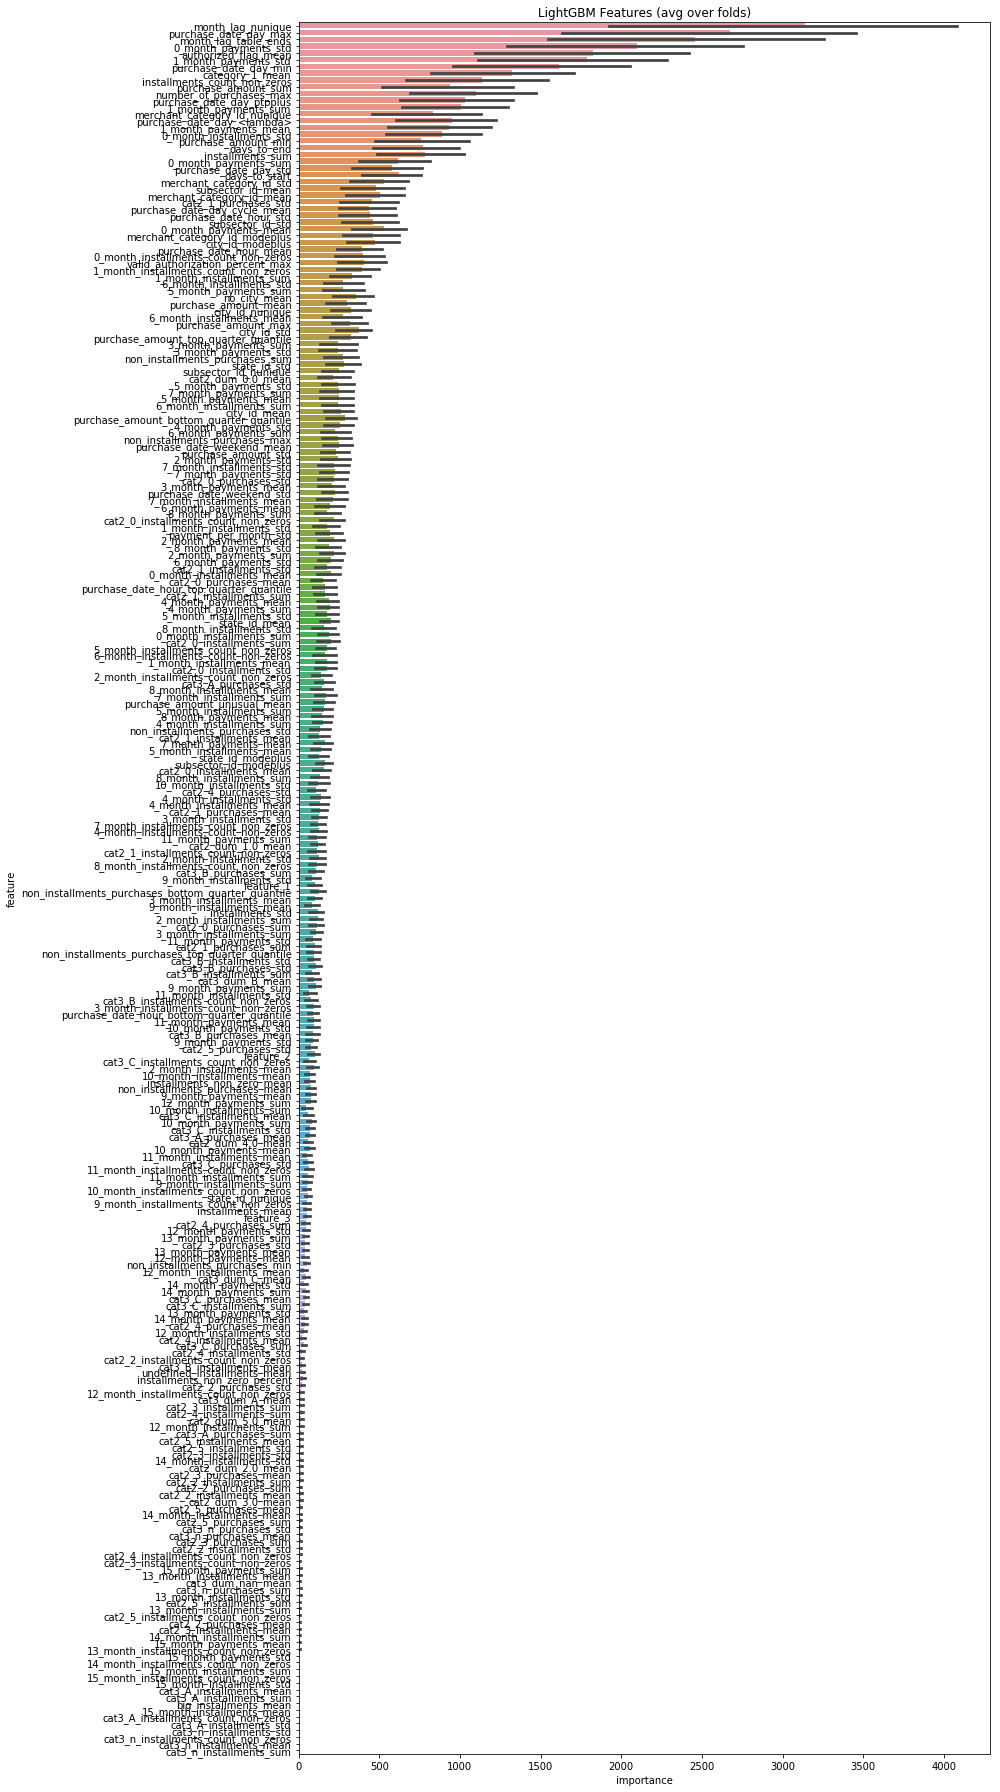

In [30]:
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [31]:
groupped = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean())

In [32]:
ndrop = groupped.sort_values(by='importance').index.values

In [10]:
ndrop

array(['cat3_n_installments_sum', 'big_installments_mean',
       'cat3_n_installments_std', 'cat3_n_installments_count_non_zeros',
       'cat3_A_installments_sum', 'cat3_A_installments_std',
       'cat3_n_installments_mean', 'cat3_A_installments_count_non_zeros',
       'cat3_A_installments_mean', '15_month_installments_sum',
       '15_month_installments_count_non_zeros',
       '15_month_installments_std', '15_month_payments_std',
       'cat2_2_purchases_mean', '14_month_installments_count_non_zeros',
       '15_month_payments_mean', 'cat3_dum_A_mean',
       '14_month_installments_sum', '15_month_installments_mean',
       'cat3_A_purchases_sum', 'cat2_3_purchases_mean',
       'cat2_3_installments_count_non_zeros', 'cat3_n_purchases_mean',
       'cat2_3_purchases_sum', 'cat2_2_purchases_sum',
       '13_month_installments_count_non_zeros', '15_month_payments_sum',
       'cat3_n_purchases_sum', 'cat2_3_installments_std',
       'cat2_3_installments_sum', 'undefined_installment

In [13]:
to_add = groupped.sort_values(by='importance').index.values

In [14]:
to_add

array(['cat3_n_installments_count_non_zeros', 'cat3_n_installments_sum',
       'big_installments_mean', 'cat3_n_installments_std',
       'cat3_n_installments_mean', 'cat3_A_installments_count_non_zeros',
       'cat3_A_installments_mean', 'cat3_A_installments_std',
       'cat3_A_installments_sum', '15_month_installments_sum',
       '15_month_installments_count_non_zeros', '15_month_payments_std',
       '15_month_installments_std', '15_month_installments_mean',
       '15_month_payments_sum', '15_month_payments_mean',
       'cat3_dum_nan_mean', '14_month_installments_count_non_zeros',
       'cat3_A_purchases_sum', 'cat3_dum_A_mean', 'cat2_2_purchases_mean',
       '14_month_installments_sum', 'cat2_2_purchases_sum',
       'cat3_B_installments_mean', 'cat2_4_installments_count_non_zeros',
       'cat2_dum_2.0_mean', '13_month_installments_sum',
       'cat3_n_purchases_mean', '14_month_installments_std',
       '14_month_installments_mean', 'cat2_4_installments_sum',
       'cat2

In [37]:
groupped[groupped.importance < 10]

,importance
feature,


In [38]:
groupped = groupped[groupped.importance < 100]

In [39]:
ndrop = groupped.index.values

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [47]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)